Manufactured Solution experiment based on SAND2000 - 1444

Test based on heat flux example in SAND2000 - 1444 Section 3

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from sympy import symbols, sin, exp, sqrt, init_printing

In [4]:
from sympy import diff, simplify, Eq, lambdify

In [5]:
init_printing(use_unicode=True)

In [6]:
x, y, t = symbols('x y t')

# symbolic form

In [7]:
T0, R, t0, k0, rho0, Cp0 = symbols('T0 R t0 k0 rho0 Cp0')

In [8]:
T_sym = T0 * (1 + sin(x/R)**2 * sin(2*y/R)**2) * exp(t*(t0-t)/t0)

In [9]:
k_sym = k0 

In [10]:
rho_sym = rho0 

In [11]:
Cp_sym = Cp0 

In [12]:
g_sym = \
simplify(diff(Cp_sym * rho_sym * T_sym, t)
         - diff(k_sym * diff(T_sym, x), x) 
         - diff(k_sym * diff(T_sym, y), y))

In [13]:
g_sym

T0*(-Cp0*R**2*rho0*(2*t - t0)*(sin(x/R)**2*sin(2*y/R)**2 + 1) + 2*k0*t0*(5*sin(x/R)**2*sin(2*y/R)**2 - 4*sin(x/R)**2*cos(2*y/R)**2 - sin(2*y/R)**2*cos(x/R)**2))*exp(-t*(t - t0)/t0)/(R**2*t0)

# substitute coefficient values

In [14]:
subs = [(R, 3.33), (T0, 100), (Cp0, 1), (rho0, 0), (k0, 1), (t0, 1)]

In [15]:
g_sub, T_sub, k_sub, rho_sub, Cp_sub = [sym.subs(subs) for sym in (g_sym, T_sym, k_sym, rho_sym, Cp_sym)]

# generate FiPy lambda functions

In [16]:
g_fp, T_fp, k_fp, rho_fp, Cp_fp = [lambdify((x, y, t), sub, modules=fp.numerix) for sub in (g_sub, T_sub, k_sub, rho_sub, Cp_sub)]

# order in space

In [ ]:
factor = 2.

In [23]:
grid_spacing = 1. * factor**fp.numerix.arange(0, -4, -1)

In [24]:
Terror2 = []
TerrorINF = []

In [26]:
for dx in grid_spacing:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    dt = 0.1
    
    while time.value <= 2.0:
        T.updateOld()
        eq.solve(var=T, dt=dt)
        time.value = time() + dt
        
    dT = T - T_fp(xx, yy, time - dt)
    
    Terror2.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    TerrorINF.append(fp.numerix.LINFnorm(dT))
    
    print dx, Terror2[-1], TerrorINF[-1]

1.0 0.503817557173 1.41167634586
0.5 0.120475931053 0.384879487428
0.25 0.0297926992543 0.0991875819048
0.125 0.00742806245874 0.0251614542358


In [27]:
from matplotlib import pyplot as plt

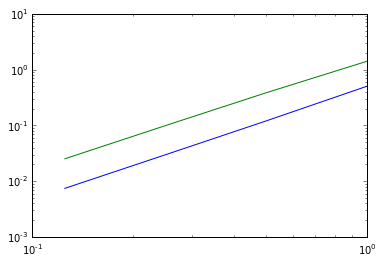

In [28]:
plt.loglog(grid_spacing, Terror2, grid_spacing, TerrorINF)

In [29]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [33]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor) - 2.

array([ 0.06415645,  0.01571421,  0.00390099])

In [ ]:
fp.numerix.log(TerrorINF[:-1] / TerrorINF[1:]) / fp.numerix.log(factor) - 2.

# order in time

In [34]:
factor = 2.

In [48]:
time_step = 1. * factor**fp.numerix.arange(0, -8, -1)

In [49]:
Terror2 = []
TerrorINF = []

In [50]:
dx = .125
for dt in time_step:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    while time.value <= 2.0:
        T.updateOld()
        time.value = time() + dt
        eq.solve(var=T, dt=dt)
        print time, max(T)
        
    dT = T - T_fp(xx, yy, time)
    
    Terror2.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    TerrorINF.append(fp.numerix.LINFnorm(dT))
    
    print dt, Terror2[-1], TerrorINF[-1]

1.0 200.065600351
2.0 27.0759362065
3.0 0.495913247859
1.0 0.000101789518359 0.000344834471523
0.5 256.889315852
1.0 200.065602286
1.5 94.5042994718
2.0 27.0759354051
2.5 4.70509214885
0.5 0.000965852204518 0.00327171036819
0.25 241.325179008
0.5 256.889317668
0.75 241.325180944
1.0 200.065602168
1.25 146.371121539
1.5 94.504299064
1.75 53.8469265543
2.0 27.0759350962
2.25 12.014873391
0.25 0.00246640847442 0.00835460729794
0.125 223.189305406
0.25 241.325180688
0.375 252.906617977
0.5 256.889317756
0.625 252.906618096
0.75 241.325180914
0.875 223.189307224
1.0 200.06560203
1.125 173.820007331
1.25 146.37112134
1.375 119.464627545
1.5 94.5042988597
1.625 72.4589594008
1.75 53.8469263868
1.875 38.7844861426
2.0 27.0759349818
2.125 18.3204940315
0.125 0.00376083005371 0.0127392555855
0.0625 212.138436628
0.125 223.189307002
0.1875 232.988494314
0.25 241.325180762
0.3125 248.014961217
0.375 252.906618028
0.4375 255.887801227
0.5 256.889317779
0.5625 255.887801257
0.625 252.906618088
0.687

In [51]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [52]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor)

array([-3.24621343, -1.3525374 , -0.60863936, -0.28741273, -0.13947965,
       -0.06868315, -0.03407741])